In [1]:
%load_ext autoreload
%autoreload 2

Dependencies

In [2]:
import pathlib as pb

# Environment
ROOT_PATH = pb.Path('..')
DATA_DIR_PATH = ROOT_PATH / 'data'
CACHE_DIR_PATH = ROOT_PATH / '.cache'
TRANSFORMERS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'transformers'
DATASETS_CACHE_DIR_PATH = CACHE_DIR_PATH / 'datasets'
TEST_DATA_FILE = DATA_DIR_PATH / 'test_data.csv'
TRAIN_DATA_FILE = DATA_DIR_PATH / 'train_data.csv'
SUBMISSIONS_DIR_PATH = ROOT_PATH / 'submissions'

In [3]:
import os

os.environ['TRANSFORMERS_CACHE'] = str(TRANSFORMERS_CACHE_DIR_PATH)
os.environ['HF_DATASETS_CACHE'] = str(DATASETS_CACHE_DIR_PATH)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torchdata
import torchtext
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset, WeightedRandomSampler
from torch import backends
import typing
import pathlib as pb
import os
import gc
from typing import List, Tuple, Dict, Set, Callable, Any
import random
import numpy as np
import pandas as pd
import platform
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score

/home/invokariman/Projects/git/nitro-lang-processing-2/.cache/pypoetry/virtualenvs/nitro-lang-processing-2-mFR9zZTH-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from utils import get_available_device, read_data, silence_warnings
from preprocess import BERTPreprocessor, MT5Preprocessor, RobertPreprocessor
from data import SexismDataset
from models import Args, Output, Ensemble, RoBertFlatClassModel, BertFlatClassModel, MT5FlatClassModel
from train import evaluate, train

Environment Setup

In [6]:
# Use available GPU
DEVICE: torch.device = get_available_device()

# Deterministic experiments
SEED = 61
random.seed(SEED)
np.random.seed(SEED)
np.random.RandomState(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# Adjust package settings
silence_warnings()

Dataset & Preprocessing

In [7]:
# Load raw dataset
train_data_raw, test_data_raw = read_data(DATA_DIR_PATH)

# Initialize custom pretraiend preprocessor
preprocessor = RobertPreprocessor()

# Create and preprocess the datasets
train_dataset = SexismDataset(train_data_raw, preprocessor)
test_dataset = SexismDataset(test_data_raw, preprocessor)

In [8]:
train_dataset.weights, train_dataset.class_to_freq

(tensor([0.9444, 0.9613, 0.9944, 0.2106, 0.8893]),
 {0: tensor(0.0005),
  1: tensor(0.0007),
  2: tensor(0.0045),
  3: tensor(3.2438e-05),
  4: tensor(0.0002)})

Model Setup

In [9]:
# Keep the training setup separately
args = Args()
model_factory: Callable[[], nn.Module] = lambda: torch.compile(RoBertFlatClassModel()).to(DEVICE)
optim_factory: Callable[..., optim.Optimizer] = lambda params: optim.AdamW(params, lr=args.learning_rate, weight_decay=args.weight_decay)
loss_fn = nn.CrossEntropyLoss(weight=train_dataset.weights.to(DEVICE))

HyperParameter Tuning using K-Fold Cross-Validation

In [10]:
# Inspired from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models: List[nn.Module] = []

for i, (train_idx, valid_idx) in enumerate(kf.split(train_dataset, train_dataset.classes)):
    print('K-FOLD: {}'.format(i))
    
    # Reinitialize the model
    model: nn.Module = model_factory()
    optimizer: optim.Optimizer = optim_factory(model.parameters())

    # Split the data
    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # Inverse frequency count for random sampling
    inv_freq = torch.tensor(list(train_dataset.class_to_freq.get(int(t['label'])) for t in train_subset))

    # Create WeightedRandomSampler
    wrs = WeightedRandomSampler(inv_freq, len(train_subset), replacement=True)

    # Create the dataloaders
    train_loader = DataLoader(train_subset, args.batch_size, sampler=wrs)
    valid_loader = DataLoader(train_subset, args.batch_size)

    # --- Validation ---
    def validation_pass() -> None:
        # --- Validation ---
        valid_output: Output = evaluate(
            model=model,
            loss_fn=loss_fn,
            data_loader=valid_loader,
            with_labels=True,
            class_to_label=train_dataset.class_to_label,
            device=DEVICE
        )
        print('Validation - Loss: {}, Accuracy: {}'.format(valid_output.loss_mean, valid_output.accy_mean))

    # --- Training ---
    train_output: Output = train(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        data_loader=train_loader,
        class_to_label=train_dataset.class_to_label,
        args=args,
        device=DEVICE,
        valid_callback=validation_pass,
    )
    print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))
    models.append(model)

K-FOLD: 0


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 09:47:42,672] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.544730544090271, Accuracy: 0.726988493505715
Validation - Loss: 0.7836114764213562, Accuracy: 0.8322841106217055
Train Epoch 1 - Loss: 0.19262149930000305, Accuracy: 0.884606084171494
Validation - Loss: 0.5790711045265198, Accuracy: 0.8912729363851808
Last Epoch - Loss: 0.19262149930000305, Accuracy: 0.884606084171494
K-FOLD: 1


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 09:49:50,548] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.5330594182014465, Accuracy: 0.7276499977979571
Validation - Loss: 0.6535806655883789, Accuracy: 0.8579192363470686
Train Epoch 1 - Loss: 0.17976990342140198, Accuracy: 0.8885806527996313
Validation - Loss: 0.49542608857154846, Accuracy: 0.9140148004491834
Last Epoch - Loss: 0.17976990342140198, Accuracy: 0.8885806527996313
K-FOLD: 2


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 09:51:56,627] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.5314991474151611, Accuracy: 0.7279934623196128
Validation - Loss: 0.765984058380127, Accuracy: 0.8401650290664003
Train Epoch 1 - Loss: 0.18397772312164307, Accuracy: 0.8873920842283635
Validation - Loss: 0.5898690223693848, Accuracy: 0.8910394533851831
Last Epoch - Loss: 0.18397772312164307, Accuracy: 0.8873920842283635
K-FOLD: 3


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 09:54:03,630] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.5440595149993896, Accuracy: 0.7237447394350552
Validation - Loss: 0.8285991549491882, Accuracy: 0.8266888768658971
Train Epoch 1 - Loss: 0.18674048781394958, Accuracy: 0.8850389581140403
Validation - Loss: 0.6250384449958801, Accuracy: 0.8898904874844462
Last Epoch - Loss: 0.18674048781394958, Accuracy: 0.8850389581140403
K-FOLD: 4


Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 09:56:10,845] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.53621506690979, Accuracy: 0.7228816751398883
Validation - Loss: 0.7751985788345337, Accuracy: 0.8382289708133747
Train Epoch 1 - Loss: 0.19238781929016113, Accuracy: 0.8831041330713979
Validation - Loss: 0.5285540819168091, Accuracy: 0.9028272950355257
Last Epoch - Loss: 0.19238781929016113, Accuracy: 0.8831041330713979


In [11]:
majority = Ensemble(models)

Training on the Whole Dataset

In [10]:
# Reinitialize the model
model: nn.Module = model_factory()
optimizer: optim.Optimizer = optim_factory(model.parameters())

# Create the dataloaders
train_loader = DataLoader(train_dataset, args.batch_size, shuffle=True)

# --- Training ---
train_output: Output = train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    data_loader=train_loader,
    class_to_label=train_dataset.class_to_label,
    args=args,
    device=DEVICE,
)
print('Last Epoch - Loss: {}, Accuracy: {}'.format(train_output.loss_mean, train_output.accy_mean))

Some weights of the model checkpoint at readerbench/RoBERT-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-03-26 10:05:32,294] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-03

Train Epoch 0 - Loss: 0.7123446464538574, Accuracy: 0.6475242061429891
Train Epoch 1 - Loss: 0.5086268186569214, Accuracy: 0.7664700317590831
Last Epoch - Loss: 0.5086268186569214, Accuracy: 0.7664700317590831


Prediction

In [14]:
test_loader: DataLoader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
test_output: Output = evaluate(
    model=model,
    loss_fn=loss_fn,
    data_loader=test_loader,
    with_labels=False,
    class_to_label=train_dataset.class_to_label,
    device=DEVICE
)

<Axes: >

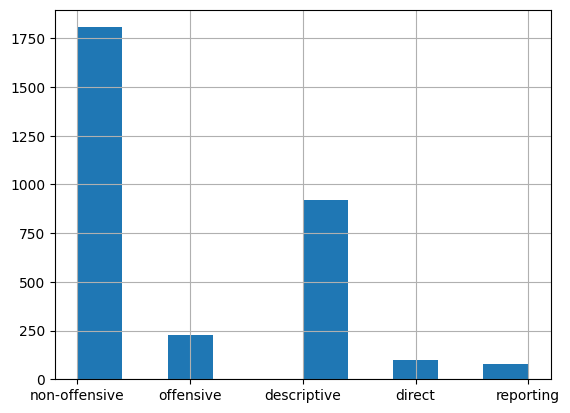

In [16]:
output: pd.DataFrame = pd.DataFrame({ 'Label': pd.Series(data=test_output.predictions_as_text) })
output = output.reset_index()
output = output.rename(columns={ 'index': 'Id' })
output.to_csv(SUBMISSIONS_DIR_PATH / 'submission_23.csv', index=False)
output['Label'].hist()

In [ ]:
# Free memory
# del model
# gc.collect()
# torch.cuda.empty_cache()